In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./input/daejeon_vds16.csv')
df.head()
df.set_index('Date', inplace=True)

spd=df.reset_index()['Speed']
windows = 60
X, y = [], []
for i in range(len(spd)-windows-1):
    X.append(spd[i:(i+windows)])
    y.append(spd[(i+windows)])

X = np.array(X)
y = np.array(y)
X.shape
X[:3]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.20, shuffle=False)
print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

X_train_ = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test_ = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_train_.shape, X_test_.shape) 

(6402, 60) (6402,)
(1601, 60) (1601,)
(6402, 60, 1) (1601, 60, 1)


In [ ]:
from tensorflow.keras.layers import LSTM
from keras import metrics
def reg_lstm():
    model = Sequential()    
    model.add(LSTM(60, return_sequences=True, input_shape=(X_train.shape[1],1)))
    model.add(LSTM(60, return_sequences=True))
    model.add(LSTM(60 ))
    model.add(Dense(1))    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics =[metrics.mae])    
    return model

model = reg_lstm()
model.summary()
history = model.fit(X_train_, y_train, epochs=30, batch_size=16, validation_split=0.2)
y_pred = model.predict(X_test_)
y_pred
model.evaluate(X_test_, y_test)

pred_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
pred_df.head()

Accuracy score of the predictions: 0.7277150987364269


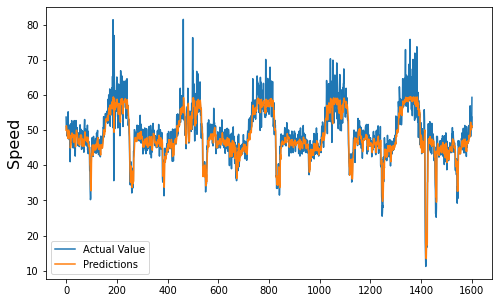

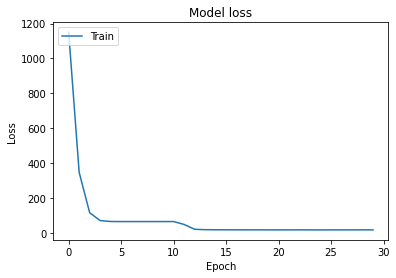

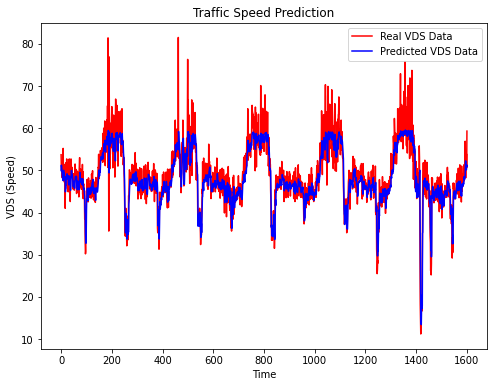

In [5]:
Acc=[]
# Measure the Accuracy Score
from sklearn.metrics import r2_score
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred)))
Acc.append(r2_score(y_test, y_pred))

plt.figure(figsize=(8,5))
plt.ylabel('Speed', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Visualising the results
plt.figure(figsize=(8,6))
plt.plot(y_test, color = 'red', label = 'Real VDS Data')
plt.plot(y_pred, color = 'blue', label = 'Predicted VDS Data')
plt.title('Traffic Speed Prediction')
plt.xlabel('Time')
plt.ylabel('VDS (Speed)')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout

In [6]:
## CNN
def reg_cnn():    
    model = Sequential()    
    model.add(Conv1D(64, kernel_size=(3,), padding='same', activation='relu', 
                     input_shape = (X_train.shape[1],1)))
    model.add(Conv1D(64, kernel_size=(3,), padding='same', activation='relu'))
    model.add(Conv1D(64, kernel_size=(5,), padding='same', activation='relu'))    
    model.add(Flatten())    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(units = 1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')    
    return model

model = reg_cnn()
model.fit(X_train_, y_train, epochs=30, validation_split=0.2)

# Prediction
y_pred = model.predict(X_test_)
pred_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
pred_df.head()

# Measure the Accuracy Score
from sklearn.metrics import r2_score
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred)))
Acc.append(r2_score(y_test, y_pred))

plt.figure(figsize=(12,8))
plt.ylabel('Speed', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

NameError: name 'Conv1D' is not defined

### G. Transformer 모델을 적용해보자

In [ ]:
from keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):    
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, 
                                  dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs   
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, 
                mlp_units, dropout=0, mlp_dropout=0):
    
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
        
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)

def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, 
                 initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

callbacks = [ tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            tf.keras.callbacks.LearningRateScheduler(lr_scheduler)      ]

input_shape = X_train_.shape[1:]
print(input_shape)
model = build_model(input_shape, head_size=46,  num_heads=60,  ff_dim=55,  
                    num_transformer_blocks=5, mlp_units=[256], mlp_dropout=0.4, dropout=0.14, )
model.compile( loss="mean_squared_error",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["mean_squared_error"])
model.summary()
history = model.fit( X_train_, y_train, validation_split=0.2, epochs=30, batch_size=20, callbacks=callbacks)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

# Prediction
y_pred = model.predict(X_test_)
pred_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
pred_df.head()

from sklearn.metrics import r2_score
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred)))
Acc.append(r2_score(y_test, y_pred))
plt.figure(figsize=(12,8))
plt.ylabel('Speed', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

plt.plot(range(4), Acc, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
plt.ylabel('Acc')
plt.xlabel('Models')
plt.title("Accuracies")
plt.xticks(range(4), ['LSTM', 'ANN', 'CNN','Transformer'])
plt.show()

## 머신러닝의 러닝커브를 위한 함수를 정의하자

## (#) Deep Neural Network
- MLP와 ReLu를 활용한 신경망을 사용하자

# 5. 머신러닝 모델을 만들자

# (1) 연습문제 해보기 : 속도
- VDS 데이터의 라벨을 속도(Speed)에 대하여 자신의 라벨을 정의하시오
- 예 (20, 50) 등 
- 훈련(Train)과 시험(Test)의 정확도 혹은 손실(Loss)를 제출하시오

# (2) 연습문제 해보기 : 교통량
### 교통량(ToVol) 혹은 SmVol로 라벨을 정하는 방법을 적용하세요
- 예 (100, 300) 등 
- 훈련(Train)과 시험(Test)의 정확도 혹은 손실(Loss)를 제출하시오

# (3) 연습문제 해보기
- VDS 데이터의 라벨을 점유률(Occ.Rate)에 대하여 자신의 라벨을 정의하시오
- 예 (8, 16) 등 
- 훈련(Train)과 시험(Test)의 정확도 혹은 손실(Loss)를 제출하시오

# (4) 연습문제 해보기
- 머신러닝 방법과 DNN 방법을 비교하여 자장 휼룡한 신경망 방법과 하이퍼파라미터를 설정하세요.